In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print("Number of training samples:", len(train_dataset))


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.47MB/s]

Number of training samples: 60000


In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28*28, 256)
        self.fc21 = nn.Linear(256, 20)
        self.fc22 = nn.Linear(256, 20)

        # Decoder
        self.fc3 = nn.Linear(20, 256)
        self.fc4 = nn.Linear(256, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)


In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [7]:
epochs = 30  # Keep this 5 to finish fast in Colab — increase if you want later

model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Average Loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1, Average Loss: 110.9722
Epoch 2, Average Loss: 109.9426
Epoch 3, Average Loss: 109.1547
Epoch 4, Average Loss: 108.5767
Epoch 5, Average Loss: 108.0366
Epoch 6, Average Loss: 107.6452
Epoch 7, Average Loss: 107.2408
Epoch 8, Average Loss: 106.9565
Epoch 9, Average Loss: 106.6411
Epoch 10, Average Loss: 106.4674
Epoch 11, Average Loss: 106.2066
Epoch 12, Average Loss: 105.9931
Epoch 13, Average Loss: 105.8421
Epoch 14, Average Loss: 105.6661
Epoch 15, Average Loss: 105.5183
Epoch 16, Average Loss: 105.3375
Epoch 17, Average Loss: 105.2488
Epoch 18, Average Loss: 105.1606
Epoch 19, Average Loss: 105.0234
Epoch 20, Average Loss: 104.8768
Epoch 21, Average Loss: 104.8175
Epoch 22, Average Loss: 104.7263
Epoch 23, Average Loss: 104.6008
Epoch 24, Average Loss: 104.5670
Epoch 25, Average Loss: 104.4638
Epoch 26, Average Loss: 104.3824
Epoch 27, Average Loss: 104.3012
Epoch 28, Average Loss: 104.2340
Epoch 29, Average Loss: 104.1497
Epoch 30, Average Loss: 104.0598


In [8]:
torch.manual_seed(42)

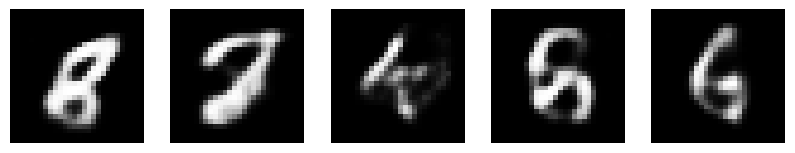

In [9]:
model.eval()
with torch.no_grad():
    z = torch.randn(5, 20).to(device)  # 5 random latent vectors
    sample = model.decode(z).cpu()
    sample = sample.view(5, 28, 28)

    # Plotting the 5 generated digits
    plt.figure(figsize=(10,2))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(sample[i], cmap='gray')
        plt.axis('off')
    plt.show()


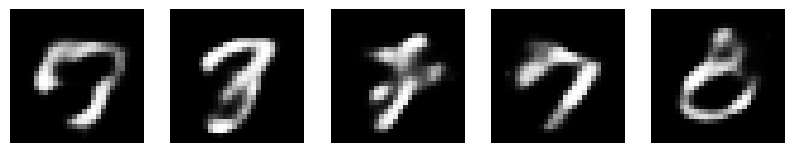

In [12]:
def generate_digit_samples(digit, num_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 20).to(device)  # 20 is latent size
        samples = model.decode(z).cpu()
        samples = samples.view(num_samples, 28, 28)

        plt.figure(figsize=(10,2))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(samples[i], cmap='gray')
            plt.axis('off')
        plt.show()

# Example: generate 5 samples of digit '1'
generate_digit_samples(1)


In [13]:
torch.save(model.state_dict(), 'vae_mnist.pth')
print("Model Saved Successfully 🎉")


Model Saved Successfully 🎉
